In [47]:
%load_ext autoreload
%autoreload all

In [ ]:
# import math
# import PIL.Image as Image
import numpy as np
# import matplotlib.pyplot as plt
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
import torch.optim as optim
from IPython.display import display, clear_output
from torch.utils.data import DataLoader
# from torch import Tensor
from datasets import load_dataset
# from torchvision import transforms
# from compressai.models import CompressionModel
# from compressai.entropy_models import EntropyBottleneck
# from compressai.ops.parametrizers import NonNegativeParametrizer
# from compressai.layers import AttentionBlock
from dance.audio import RateDistortionAutoEncoder
import fastprogress
from fastprogress.fastprogress import master_bar, progress_bar
import matplotlib.pyplot as plt
from ipywidgets import Output

In [ ]:
dataset = load_dataset("danjacobellis/aria_ea_audio").with_format("torch")
dataset = concatenate_datasets([dataset[key] for key in dataset.keys()])

In [40]:
def preprocess(sample):
    x = sample['audio'].to(torch.float)
    xr = x.transpose(0, 1).unsqueeze(0)
    num_channels = xr.size(1)
    kernel_size = 33
    kernel = torch.ones(num_channels, 1, kernel_size) / kernel_size
    smoothed_signal = F.conv1d(xr, kernel, padding='same', groups=num_channels)
    smoothed_signal = smoothed_signal.squeeze(0).transpose(0, 1)
    filtered_signal = x - smoothed_signal
    scaled_signal = (filtered_signal/(2**23)).tanh()
    sample['audio'] = scaled_signal
    return sample

In [46]:
dataset = dataset.select(range(720))

Map:   0%|          | 0/720 [00:00<?, ? examples/s]

In [106]:
train_dataset = dataset.select(range(540)).map(preprocess, writer_batch_size=400)
valid_dataset = dataset.select(range(540,720)).map(preprocess, writer_batch_size=400)

Map:   0%|          | 0/180 [00:00<?, ? examples/s]

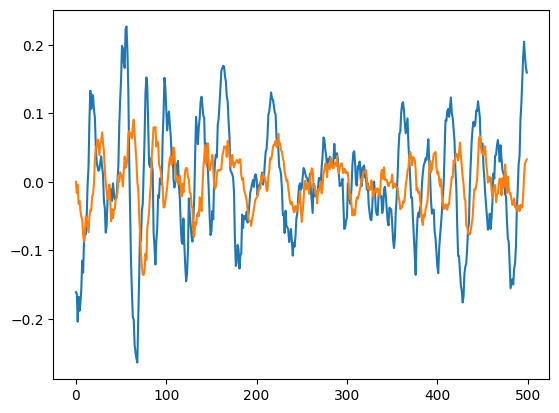

In [153]:
test_sample = valid_dataset[30]['audio'].unsqueeze(0)
test_input = test_sample.permute(0,2,1).to("cuda")
plt.plot(test_sample[0,39500:40000,[0,3]])

In [85]:
model = RateDistortionAutoEncoder().to("cuda")
parameters = set(p for n, p in model.named_parameters() if not n.endswith(".quantiles"))
aux_parameters = set(p for n, p in model.named_parameters() if n.endswith(".quantiles"))
optimizer = optim.AdamW(parameters, lr=1e-4)
aux_optimizer = optim.AdamW(aux_parameters, lr=1e-3)
λ = 0.01

Output()

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ecfa8ae9750>
Traceback (most recent call last):
  File "/home/dgj335/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/dgj335/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ecfa8ae9750>assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7ecfa8ae9750>
Traceback (most recent call last):


Traceback (most recent call last):
AssertionError  File "/home/dgj335/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
:   File "/home/dgj335/.local/lib/python3.10/site-packages/t

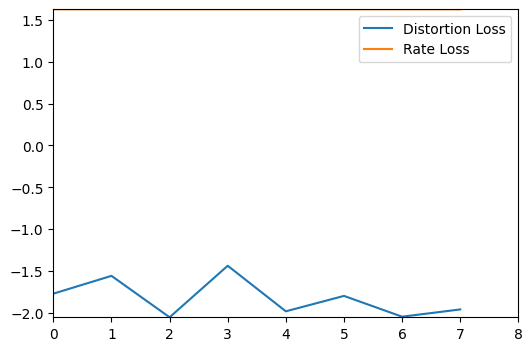

In [ ]:
epochs = 5
mb = master_bar(range(epochs))
mb.names = ['Distortion Loss', 'Rate Loss']
dist_losses, rate_losses = [], []
output_plot = Output()
display(output_plot)
model.train()

desired_batch_size = 32
actual_batch_size = 4
accumulation_steps = desired_batch_size // actual_batch_size

for i_epoch in mb:
    dataloader = DataLoader(train_dataset, batch_size=actual_batch_size, shuffle=True, drop_last=True, num_workers=6)
    
    for i, batch in enumerate(progress_bar(dataloader, parent=mb)):
        x = batch['audio'].permute(0,2,1).to("cuda").to(torch.float)        
        x_hat, y_likelihoods = model(x)
        N, _, L = x.size()
        num_samples = N * L
        rate_loss = torch.log(y_likelihoods).sum() / (-torch.log(torch.tensor(2)) * num_samples)
        dist_loss = F.mse_loss(x, x_hat)
        loss = dist_loss +  λ * rate_loss

        loss.backward()
        model.aux_loss().backward()
        if (i + 1) % accumulation_steps == 0: 
            optimizer.step()
            aux_optimizer.step()
            optimizer.zero_grad()
            aux_optimizer.zero_grad()

        dist_losses.append(np.log10(dist_loss.item()))
        rate_losses.append(np.log10(rate_loss.item()))
        
        if (i + 1) % accumulation_steps == 0:
            
            mb.update_graph(
                [[range(len(dist_losses)), dist_losses], [range(len(rate_losses)), rate_losses]],
                [0, i_epoch*len(dataloader)+i+1],
                [min(min(dist_losses), min(rate_losses)), max(max(dist_losses), max(rate_losses))]
            )
            with torch.no_grad():
                test_output = model.decode(model.encode(test_input).round())
                test_output = test_output.permute(0,2,1).cpu()

            with output_plot:
                output_plot.clear_output(wait=True)
                plt.figure(figsize=(10, 4))
                plt.plot(test_sample[0,39500:40000,[0,3]].numpy(), label='Original')
                plt.plot(test_output[0,39500:40000,[0,3]].numpy(), label='Reconstructed')
                plt.legend()
                plt.show()